In [21]:
!pip install mesa
!pip install  PyHamcrest
!pip install panel --user

cookiecutter 1.7.2 has requirement click>=7.0, but you'll have click 6.7 which is incompatible.
You are using pip version 10.0.1, however version 20.3b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


cookiecutter 1.7.2 has requirement click>=7.0, but you'll have click 6.7 which is incompatible.
You are using pip version 10.0.1, however version 20.3b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


cookiecutter 1.7.2 has requirement click>=7.0, but you'll have click 6.7 which is incompatible.
You are using pip version 10.0.1, however version 20.3b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Imports

In [22]:
import time
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import enum

In [23]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

Loading BokehJS ...

ModuleNotFoundError: No module named 'panel'

In [ ]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    SEVERE = 2
    DIED = 3
    HEALED = 4

# Define Agent

In [5]:
class Human(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = self.random.normalvariate(self.model.age,self.model.agesd)
        self.wear_mask = np.random.choice([0,1], p=[self.model.proba_wear_mask,1-self.model.proba_wear_mask])
        self.state = State.SUSCEPTIBLE  
        self.infection_time = 0
        self.severe_time = 0
        self.healed_time = 0
        self.recovery_severe_time = 0

    def move(self):
        """Move the agent"""
        if self.state != State.SEVERE and self.state != State.DIED and self.random.random() < self.model.proba_move:
            
            if self.random.random() < self.model.proba_go_to_places:
                pos_places = self.model.places[self.random.randint(0,len(self.model.places) - 1)]
                possible_steps = self.model.grid.get_neighborhood(
                pos_places,
                moore=True,
                include_center=True)
                new_position = self.random.choice(possible_steps)
                self.model.grid.move_agent(self, new_position)
            else:
                possible_steps = self.model.grid.get_neighborhood(
                self.pos,
                moore=True,
                include_center=False)
                new_position = self.random.choice(possible_steps)
                self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
        
        if self.state == State.INFECTED:             
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:
                self.healed_time = self.model.schedule.time
                self.state = State.HEALED
            else:
                drate = self.model.infected_to_death_proba(t)
                alive = np.random.choice([0,1], p=[drate,1-drate])
                if alive == 0: 
                    self.state = State.DIED
                    if self.age >= self.model.age_old:
                        self.model.old_died = self.model.old_died + 1
                    else:
                        self.model.young_died = self.model.young_died + 1
                    #self.model.schedule.remove(self)
                else:
                    if self.age < self.model.age_old:
                        to_severe = self.model.infected_young_to_severe_proba(t)
                    else:
                        to_severe = self.model.infected_old_to_severe_proba(t)
                    severe = np.random.choice([0,1], p=[to_severe,1-to_severe])
                    if severe == 0:
                        self.severe_time = self.model.schedule.time
                        self.state = State.SEVERE
                        
        elif self.state == State.SEVERE:
            t = self.model.schedule.time-self.severe_time
            if t >= self.recovery_severe_time:
                self.healed_time = self.model.schedule.time
                self.state = State.HEALED
            else:
                if self.age < self.model.age_old:
                    drate = self.model.severe_young_to_death(t)
                else:
                    drate = self.model.severe_old_to_death(t)
                alive = np.random.choice([0,1], p=[drate,1-drate])
                if alive == 0: 
                    self.state = State.DIED
                    if self.age >= self.model.age_old:
                        self.model.old_died = self.model.old_died + 1
                    else:
                        self.model.young_died = self.model.young_died + 1
                    #self.model.schedule.remove(self)
                                               
        elif self.state == State.HEALED:
            t = self.model.schedule.time-self.healed_time
            if t > self.model.immunity_time:
                proba = self.model.healed_to_susceptible(t)
                suscep = np.random.choice([0,1], p=[proba,1-proba])
                if suscep == 0:
                    self.state = State.SUSCEPTIBLE

    def contact(self):
        """Find close contacts and infect"""
        
        if self.state != State.DIED:
            cellmates = self.model.grid.get_cell_list_contents([self.pos])       
            if len(cellmates) > 1:
                #other = self.random.choice(cellmates)
                if self.wear_mask == 0:
                    ptrans = self.model.ptrans_mask
                else:
                    ptrans = self.model.ptrans
                for other in cellmates:
                    #print (self.model.schedule.time,self.state,other.state)
                    if self.random.random() > ptrans:
                        continue
                    if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                        other.state = State.INFECTED
                        other.infection_time = self.model.schedule.time
                        other.recovery_time, other.recovery_severe_time = model.get_recovery_time(other.age)

    def step(self):
        self.status()
        self.move()
        self.contact()

# Define the model

In [6]:
class InfectionModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=1000, width=20, height=20, ptrans=0.5, ptrans_mask = 0.1,
                 progression_period=3, progression_sd=2, infected_to_death_proba = lambda t: 0.001, 
                 severe_young_to_death = lambda t: 0.05 * (t + 1) if t < 9 else 0.5, severe_old_to_death = lambda t: 0.07 * (t+1) if t<9 else 0.7,
                 infected_young_to_severe_proba = lambda t: 0.04, infected_old_to_severe_proba = lambda t: 0.1, 
                 recovery_young_days=14, recovery_young_sd=7, recovery_old_days=21, recovery_old_sd = 7,
                 recovery_severe_young_days=14, recovery_severe_young_sd=7, recovery_severe_old_days=21, recovery_severe_old_sd = 7,
                 proba_wear_mask=0.5, proba_move = 0.5, initial_outbreak_size = 10, age_old = 50,
                immunity_time = 20, healed_to_susceptible = lambda t: 0.01, agesd = 40, age = 25, nb_places = 5, proba_go_to_places = 0.5):
        
        self.age = age
        self.agesd = agesd
        self.immunity_time = immunity_time
        self.healed_to_susceptible = healed_to_susceptible
        self.proba_move = proba_move
        self.proba_wear_mask = proba_wear_mask
        self.num_agents = N
        self.initial_outbreak_size = initial_outbreak_size
        self.recovery_old_days = recovery_old_days
        self.recovery_old_sd = recovery_old_sd
        self.recovery_young_days = recovery_young_days
        self.recovery_young_sd = recovery_young_sd
        self.recovery_severe_old_days = recovery_severe_old_days
        self.recovery_severe_old_sd = recovery_severe_old_sd
        self.recovery_severe_young_days = recovery_severe_young_days
        self.recovery_severe_young_sd = recovery_severe_young_sd
        self.ptrans = ptrans
        self.ptrans_mask = ptrans_mask
        self.age_old = age_old
        self.old_died = 0
        self.young_died = 0
        #for these probas, t is the number of days till the infection/severe started.
        self.infected_to_death_proba = infected_to_death_proba
        self.severe_young_to_death = severe_young_to_death
        self.severe_old_to_death = severe_old_to_death
        self.infected_young_to_severe_proba = infected_young_to_severe_proba
        self.infected_old_to_severe_proba = infected_old_to_severe_proba
        
        self.nb_places = nb_places
        self.proba_go_to_places = proba_go_to_places
        self.places = []
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        
        self.nb_old_people = 0
        
        for i in range(self.nb_places):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.places.append((x,y))
        
        # Create agents
        j = 1
        for i in range(self.num_agents):
            a = Human(i, self)
            self.schedule.add(a)
            
            if a.age >= self.age_old:
                self.nb_old_people = self.nb_old_people + 1
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            #make some agents infected at start
            #proba_infected = self.initial_outbreak_size/self.num_agents
            #infected = np.random.choice([0,1], p=[proba_infected,1-proba_infected])
            #if infected == 0:
            #    a.state = State.INFECTED
            #    a.recovery_time = self.get_recovery_time(a.age)
            
            if j <= self.initial_outbreak_size:
                a.state = State.INFECTED
                a.recovery_time, a.recovery_severe_time = self.get_recovery_time(a.age)
                j = j+1
        self.datacollector = DataCollector(
            #model_reporters={"Gini": compute_gini}, 
            agent_reporters={"State": "state"})

    def get_recovery_time(self, age):
        if age >= self.age_old:
            recovery_time = int(self.random.normalvariate(self.recovery_old_days,self.recovery_old_sd))
            recovery_severe_time = int(self.random.normalvariate(self.recovery_severe_old_days,self.recovery_severe_old_sd))
        else:
            recovery_time = int(self.random.normalvariate(self.recovery_young_days,self.recovery_young_sd))
            recovery_severe_time = int(self.random.normalvariate(self.recovery_severe_young_days,self.recovery_severe_young_sd))
        return recovery_time, recovery_severe_time
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [7]:

def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)
    labels = ['Susceptible','Infected','Severe', 'Died', 'Healed']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=4,alpha=0.8)

# Function to plot the cells

In [8]:
def plot_cells_bokeh(model):
    
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    w=model.grid.width
    df=grid_values(model) 
    df = pd.DataFrame(df.stack(), columns=['value']).reset_index()    
    columns = ['value']
    x = [(i, "@%s" %i) for i in columns]    
    hover = HoverTool(
        tooltips=x, point_policy='follow_mouse')
    colors = Category10[3]
    mapper = LinearColorMapper(palette=colors, low=df.value.min(), high=df.value.max())
    p = figure(plot_width=500,plot_height=500, tools=[hover], x_range=(-1,w), y_range=(-1,w))
    p.rect(x="level_0", y="level_1", width=1, height=1,
       source=df,
       fill_color={'field':'value', 'transform': mapper},
       line_color='black')
    p.background_fill_color = "white"
    p.grid.grid_line_color = None    
    p.axis.axis_line_color = None
    p.toolbar.logo = None
    return p

In [9]:
def grid_values(model):
    """Get grid states"""
    
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        agents, x, y = cell
        c=None
        for a in agents:
            c = a.state
        agent_counts[x,y] = c
    df=pd.DataFrame(agent_counts)  
    return df

# Run the model 1: Lockdown applied

In [10]:
pop=30000
steps=300
initial_infected = 300
st=time.time()
model = InfectionModel(N=pop, width=400, height=400, ptrans=0.2, ptrans_mask = 0.03,
                 infected_to_death_proba = lambda t: 0.008, severe_young_to_death = lambda t: 0.004 * (t + 1) if t < 10 else 0.05,
                       severe_old_to_death = lambda t: 0.02 * (t+1) if t<9 else 0.2,
                 infected_young_to_severe_proba = lambda t: 0.01, infected_old_to_severe_proba = lambda t: 0.2, 
                 recovery_young_days=14, recovery_young_sd=7, recovery_old_days=21, recovery_old_sd = 7,
                recovery_severe_young_days=7, recovery_severe_young_sd=3, recovery_severe_old_days=14, recovery_severe_old_sd = 7,
                 proba_wear_mask=0.9, proba_move = 0.04, initial_outbreak_size = initial_infected, age_old = 50, nb_places = 20, proba_go_to_places = 0.004,
                immunity_time = 30, healed_to_susceptible = lambda t: 0.0003, agesd = 20, age = 30)
for i in range(steps):
    model.step()
print ("Time " + str(time.time( )-st))
agent_state = model.datacollector.get_agent_vars_dataframe()
print("Number of old people: " + str(model.nb_old_people))
print("Number of old people's deaths: " + str(model.old_died) + " Number of young people's deaths: " + str(model.young_died))
#print (get_column_data(model))

Time 71.58468079566956
Number of old people: 4733
Number of old people's deaths: 37 Number of young people's deaths: 23


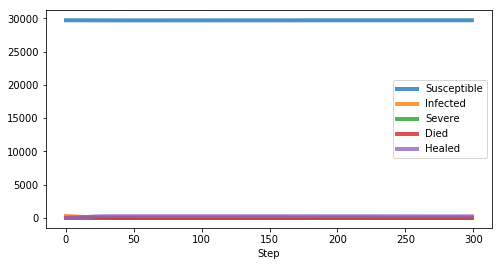

In [11]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SISDH_lock.png',dpi=150)

# Vizualise the model's state

In [12]:
st=time.time()
x=grid_values(model)
#temps mis
print (time.time()-st)

0.08177566528320312


In [13]:
p=plot_cells_bokeh(model)
pn.pane.Bokeh(p)

NameError: name 'pn' is not defined

# Run the model 2: No lockdown applied

In [32]:
pop=30000
steps=300
initial_infected = 300
st=time.time()
model = InfectionModel(N=pop, width=400, height=400, ptrans=0.2, ptrans_mask = 0.03,
                 infected_to_death_proba = lambda t: 0.008, severe_young_to_death = lambda t: 0.004 * (t + 1) if t < 10 else 0.05,
                       severe_old_to_death = lambda t: 0.02 * (t+1) if t<9 else 0.2,
                 infected_young_to_severe_proba = lambda t: 0.01, infected_old_to_severe_proba = lambda t: 0.2, 
                 recovery_young_days=14, recovery_young_sd=7, recovery_old_days=21, recovery_old_sd = 7,
                recovery_severe_young_days=7, recovery_severe_young_sd=3, recovery_severe_old_days=14, recovery_severe_old_sd = 7,
                 proba_wear_mask=0.1, proba_move = 0.6, initial_outbreak_size = initial_infected, age_old = 50, nb_places = 20, proba_go_to_places = 0.2,
                immunity_time = 30, healed_to_susceptible = lambda t: 0.0003, agesd = 20, age = 30)
for i in range(steps):
    model.step()
print ("Time " + str(time.time( )-st))
agent_state = model.datacollector.get_agent_vars_dataframe()
print("Number of old people: " + str(model.nb_old_people))
print("Number of old people's deaths: " + str(model.old_died) + " Number of young people's deaths: " + str(model.young_died))
#print (get_column_data(model))

Time 130.4657163619995
Number of old people: 1580
Number of old people's deaths: 1107 Number of young people's deaths: 875


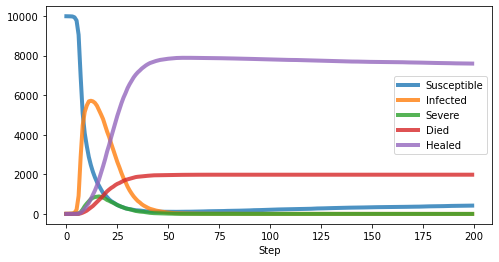

In [33]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SISDH_nolock.png',dpi=150)

## Visualize the data

In [34]:
st=time.time()
x=grid_values(model)
#temps mis
print (time.time()-st)

0.1484677791595459


In [35]:
p=plot_cells_bokeh(model)
pn.pane.Bokeh(p)

Bokeh(Figure)

# Distancing Measures

In [ ]:
pop=30000
steps=300
initial_infected = 300
st=time.time()
model = InfectionModel(N=pop, width=400, height=400, ptrans=0.2, ptrans_mask = 0.03,
                 infected_to_death_proba = lambda t: 0.008, severe_young_to_death = lambda t: 0.004 * (t + 1) if t < 10 else 0.05,
                       severe_old_to_death = lambda t: 0.02 * (t+1) if t<9 else 0.2,
                 infected_young_to_severe_proba = lambda t: 0.01, infected_old_to_severe_proba = lambda t: 0.2, 
                 recovery_young_days=14, recovery_young_sd=7, recovery_old_days=21, recovery_old_sd = 7,
                recovery_severe_young_days=7, recovery_severe_young_sd=3, recovery_severe_old_days=14, recovery_severe_old_sd = 7,
                 proba_wear_mask=0.6, proba_move = 0.5, initial_outbreak_size = initial_infected, age_old = 50, nb_places = 20, proba_go_to_places = 0.2,
                immunity_time = 30, healed_to_susceptible = lambda t: 0.0003, agesd = 20, age = 30)
for i in range(steps):
    model.step()
print ("Time " + str(time.time( )-st))
agent_state = model.datacollector.get_agent_vars_dataframe()
print("Number of old people: " + str(model.nb_old_people))
print("Number of old people's deaths: " + str(model.old_died) + " Number of young people's deaths: " + str(model.young_died))
#print (get_column_data(model))

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SISDH_measures.png',dpi=150)

## Visualize the data 

In [ ]:
st=time.time()
x=grid_values(model)
#temps mis
print (time.time()-st)

In [ ]:
p=plot_cells_bokeh(model)
pn.pane.Bokeh(p)

# Recap of Diverse Strategies

In [24]:
# Code to plot the evolution of infected people in regards of wether lockdown is applied, no lockdown or simple measures
#

# OLD CODE

In [36]:
def plot_states_bokeh(model,steps = 100, title=''):
    """Plot cases per country"""
        
    X = get_column_data(model)
    X = X.reset_index()
    source = ColumnDataSource(X)
    i=0
    colors = Category10[5]
    items=[]
    p = figure(plot_width=600,plot_height=400,tools=[],title=title,x_range=(0,steps))        
    for c in X.columns[1:]:
        line = Line(x='Step',y=c, line_color=colors[i],line_width=3,line_alpha=.8,name=c)
        glyph = p.add_glyph(source, line)
        i+=1
        items.append((c,[glyph]))

    p.xaxis.axis_label = 'Step'
    p.add_layout(Legend(location='center_right',   
                items=items))
    p.background_fill_color = "#e1e1ea"
    p.background_fill_alpha = 0.5
    p.legend.label_text_font_size = "10pt"
    p.title.text_font_size = "15pt"
    p.toolbar.logo = None
    p.sizing_mode = 'scale_height'    
    return p

p = plot_states_bokeh(model)
#pn.pane.Bokeh(p)